In [1]:
rm(list = ls())

In [2]:
library(ggplot2)

library(caret)
library(NLP)
library(tm)
library(factoextra)
library(tidyverse)
library(e1071)

library(rpart)
library(rpart.plot)

library(glmnet)
library(e1071)

Loading required package: lattice


Attaching package: 'NLP'


The following object is masked from 'package:ggplot2':

    annotate


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.3     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x NLP::annotate() masks ggplot2::annotate()
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x purrr::lift()   masks caret::lift()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.0-2



In [3]:

PATH = "../../../archive/US_Accidents_June20_clean_northeast.csv"
traffic_df <- data.frame(read.csv(PATH, header=TRUE, sep = ","))
set.seed(42)
traffic.sampled.df <- traffic_df[sample(nrow(traffic_df), 50000),]

PATH = "../../../archive/US_Accidents_June20_clean_midwest.csv"
traffic_df <- data.frame(read.csv(PATH, header=TRUE, sep = ","))
traffic.sampled.df <- rbind(traffic.sampled.df, traffic_df[sample(nrow(traffic_df), 50000),])

PATH = "../../../archive/US_Accidents_June20_clean_south.csv"
traffic_df <- data.frame(read.csv(PATH, header=TRUE, sep = ","))
traffic.sampled.df <- rbind(traffic.sampled.df, traffic_df[sample(nrow(traffic_df), 50000),])

PATH = "../../../archive/US_Accidents_June20_clean_west.csv"
traffic_df <- data.frame(read.csv(PATH, header=TRUE, sep = ","))
traffic.sampled.df <- rbind(traffic.sampled.df, traffic_df[sample(nrow(traffic_df), 50000),])

rm(traffic_df)

In [4]:
summary(traffic.sampled.df)

       X                ID                 TMC           Severity     
 Min.   :      6   Length:200000      Min.   :200.0   Min.   :0.0000  
 1st Qu.: 864844   Class :character   1st Qu.:201.0   1st Qu.:0.0000  
 Median :1759582   Mode  :character   Median :201.0   Median :0.0000  
 Mean   :1755623                      Mean   :208.2   Mean   :0.3335  
 3rd Qu.:2633726                      3rd Qu.:201.0   3rd Qu.:1.0000  
 Max.   :3513606                      Max.   :406.0   Max.   :1.0000  
                                      NA's   :59603                   
  Start_Time          End_Time           Start_Lat       Start_Lng      
 Length:200000      Length:200000      Min.   :24.56   Min.   :-124.50  
 Class :character   Class :character   1st Qu.:34.12   1st Qu.:-104.82  
 Mode  :character   Mode  :character   Median :39.39   Median : -86.26  
                                       Mean   :38.08   Mean   : -91.73  
                                       3rd Qu.:41.62   3rd Qu.: -77

In [53]:
traffic.sampled.df[1000:1010, "Weather_Condition"]

[1] "Light Rain"       "Mostly Cloudy"    "Partly Cloudy"    "Overcast"        
 [5] "Cloudy"           "Cloudy"           "Overcast"         "Scattered Clouds"
 [9] "Rain"             "Mostly Cloudy"    "Overcast"

In [5]:
nrow(traffic.sampled.df)

[1] 200000

In [6]:
traffic.sampled.df$Severity <- as.factor(traffic.sampled.df$Severity)
traffic.sampled.df$Weather <- as.factor(traffic.sampled.df$Weather)
traffic.sampled.df$is_highway <- as.factor(traffic.sampled.df$is_highway)
traffic.sampled.df$region <- as.factor(traffic.sampled.df$region)
traffic.sampled.df$TMC <- as.factor(traffic.sampled.df$TMC)
traffic.sampled.df$Wind_Direction <- as.factor(traffic.sampled.df$Wind_Direction)
traffic.sampled.df$Sunrise_Sunset <- as.factor(traffic.sampled.df$Sunrise_Sunset) 
traffic.sampled.df$Traffic_Signal <- as.factor(traffic.sampled.df$Traffic_Signal)
traffic.sampled.df$Junction <- as.factor(traffic.sampled.df$Junction)
traffic.sampled.df$State <- as.factor(traffic.sampled.df$State)

traffic.sampled.df$TMC <- addNA(traffic.sampled.df$TMC)

In [7]:
summary(traffic.sampled.df$TMC)

200    201    202    203    206    222    229    236    239    241    244 
     5 117013    361   1295     86    831   1713    148      2  14134    768 
   245    246    247    248    336    339    341    343    351    406   <NA> 
  2145    333    321     42      5     72     37    441      1    644  59603

In [8]:
traffic.pca <- prcomp(
    traffic.sampled.df[,c("Temperature.F.", "Visibility.mi.", "Wind_Chill.F.", "Humidity...", "Pressure.in.", "Wind_Speed.mph.", "Time_Elapsed")], 
    rank. = 2, 
    scale. = TRUE,
)

In [9]:
summary(traffic.pca)

Importance of first k=2 (out of 7) components:
                          PC1    PC2
Standard deviation     1.4556 1.1192
Proportion of Variance 0.3027 0.1790
Cumulative Proportion  0.3027 0.4816

In [10]:
summary(traffic.pca)$importance

,PC1,PC2,,,,,
Standard deviation,1.455565,1.119238,1.004701,0.9999682,0.9522472,0.7406481,0.4048982
Proportion of Variance,0.302670,0.178960,0.144200,0.1428500,0.1295400,0.0783700,0.0234200
Cumulative Proportion,0.302670,0.481620,0.625830,0.7686700,0.8982100,0.9765800,1.0000000


Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
Warning message in var.loadings * comp.sdev:
"longer object length is not a multiple of shorter object length"
W

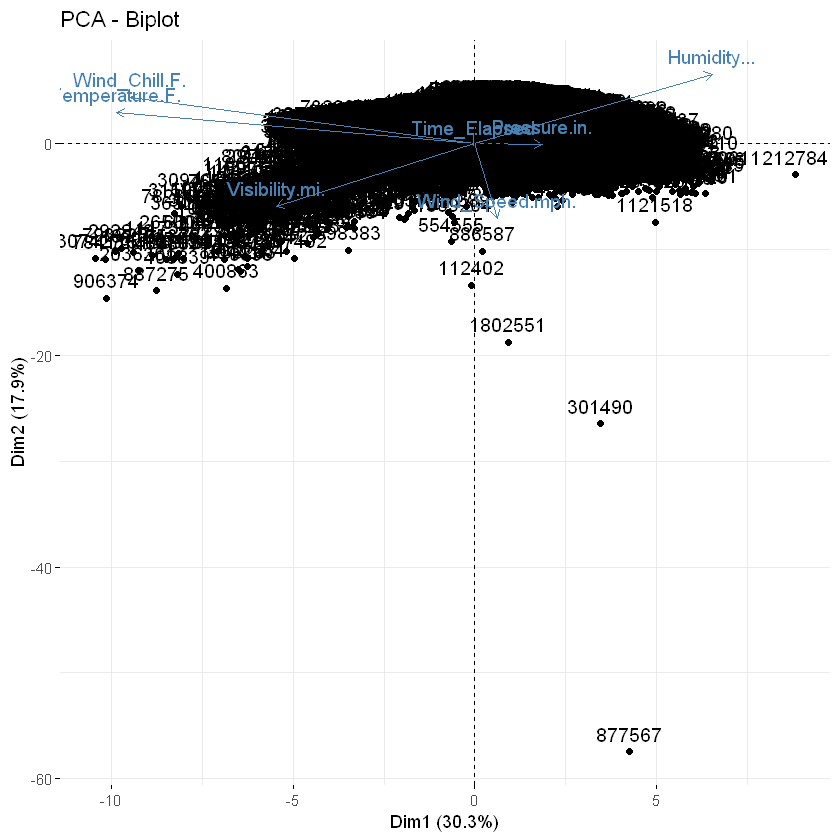

In [11]:
fviz_pca_biplot(traffic.pca)

In [12]:
# try pca with glm 

# separate training and testing here

set.seed(42)
part <- createDataPartition(
  traffic.sampled.df$Severity,
  times=1,
  p=0.8, #0.8 goes into training
 list=FALSE,
)

In [13]:
traffic.train.df <- traffic.sampled.df[part,]
traffic.test.df <- traffic.sampled.df[-part,]

In [14]:
c(
    "Training: ", nrow(traffic.train.df), 
    "Testing:", nrow(traffic.test.df)
)

[1] "Training: " "160001"     "Testing:"   "39999"

In [15]:
run_glm <- function(COL){
    
    print(glm.COL)
    glm.fit <- glm(
        as.formula(paste("Severity~", paste(COL, collapse = "+"))),
        data=traffic.train.df,
        family=binomial
    )
    print(summary(glm.fit))

    # train set
    traffic.train.prob <- predict(
        glm.fit, 
        type = "response"
    )
    traffic.train.preds <- rep(
        0,
        nrow(traffic.train.df)
    )
    traffic.train.preds[traffic.train.prob>.5]=1
    traffic.train.preds <- as.factor(traffic.train.preds)

    # test set
    traffic.test.prob <- predict(
        glm.fit, 
        type = "response",
        newdata=traffic.test.df[, COL]
    )
    traffic.test.preds <- rep(
        0,
        nrow(traffic.test.df)
    )
    traffic.test.preds[traffic.test.prob>.5]=1
    traffic.test.preds <- as.factor(traffic.test.preds)

    print(confusionMatrix(
        traffic.train.preds, 
        traffic.train.df$Severity, 
        positive='1',
    ))

    print(confusionMatrix(
        traffic.test.preds, 
        traffic.test.df$Severity, 
        positive='1'
    ))
    
}

In [16]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Visibility.mi.",
             "Wind_Direction",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "is_highway",
             "region",
             "Time_Elapsed",
             "Weather"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Wind_Chill.F."   "Humidity..."     "Pressure.in."   
 [5] "Visibility.mi."  "Wind_Direction"  "Wind_Speed.mph." "Sunrise_Sunset" 
 [9] "is_highway"      "region"          "Time_Elapsed"    "Weather"        

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6494  -0.8394  -0.6553   1.1184   2.4447  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.285e+00  2.754e-01 -11.928  < 2e-16 ***
Temperature.F.          7.967e-03  5.639e-04  14.129  < 2e-16 ***
Wind_Chill.F.          -3.009e-03  6.103e-04  -4.930 8.20e-07 ***
Humidity...            -2.826e-03  3.384e-04  -8.352  < 2e-16 ***
Pressure.in.            5.288e-02  8.895e-03   5.946 2.75e-09 ***
Visibility.mi.          1.404e-02  2.358e-03   5.954 2.62e-09 ***
Wind_DirectionCalm      2.288e-01  5.104e-02   4

In [17]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Visibility.mi.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "is_highway",
             "region",
             "Weather"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Wind_Chill.F."   "Humidity..."     "Pressure.in."   
 [5] "Visibility.mi."  "Wind_Speed.mph." "Sunrise_Sunset"  "is_highway"     
 [9] "region"          "Weather"        

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7358  -0.8497  -0.6575   1.1250   2.4480  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.9740378  0.2651739 -18.758  < 2e-16 ***
Temperature.F.         0.0090374  0.0005444  16.601  < 2e-16 ***
Wind_Chill.F.         -0.0041191  0.0005799  -7.103 1.22e-12 ***
Humidity...           -0.0024737  0.0003325  -7.440 1.01e-13 ***
Pressure.in.           0.1086403  0.0087141  12.467  < 2e-16 ***
Visibility.mi.         0.0148592  0.0023538   6.313 2.74e-10 ***
Wind_Speed.mph.        0.0105230  0.0012367   8.509  < 2e-16 ***
Sunrise_SunsetNight    0.3

In [18]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Visibility.mi.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "is_highway",
             "region",
             "Weather",
             "Traffic_Signal",
             "Junction"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Wind_Chill.F."   "Humidity..."     "Pressure.in."   
 [5] "Visibility.mi."  "Wind_Speed.mph." "Sunrise_Sunset"  "is_highway"     
 [9] "region"          "Weather"         "Traffic_Signal"  "Junction"       

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8954  -0.8746  -0.6079   1.1086   2.6616  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.6164052  0.2671577 -17.280  < 2e-16 ***
Temperature.F.         0.0094063  0.0005491  17.129  < 2e-16 ***
Wind_Chill.F.         -0.0042501  0.0005847  -7.269 3.62e-13 ***
Humidity...           -0.0027662  0.0003353  -8.250  < 2e-16 ***
Pressure.in.           0.1037317  0.0087764  11.819  < 2e-16 ***
Visibility.mi.         0.0156115  0.0023751   6.573 4.93e-11 ***
Wind_Speed.mph.        0.0110515  0.0012466   8.865  < 

In [19]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Visibility.mi.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "is_highway",
             "region",
             "Weather",
             "Traffic_Signal"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Wind_Chill.F."   "Humidity..."     "Pressure.in."   
 [5] "Visibility.mi."  "Wind_Speed.mph." "Sunrise_Sunset"  "is_highway"     
 [9] "region"          "Weather"         "Traffic_Signal" 

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.8892  -0.8746  -0.6079   1.1091   2.6604  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.5988594  0.2668720 -17.232  < 2e-16 ***
Temperature.F.         0.0093995  0.0005491  17.117  < 2e-16 ***
Wind_Chill.F.         -0.0042539  0.0005847  -7.276 3.45e-13 ***
Humidity...           -0.0027645  0.0003353  -8.245  < 2e-16 ***
Pressure.in.           0.1031256  0.0087662  11.764  < 2e-16 ***
Visibility.mi.         0.0155991  0.0023751   6.568 5.11e-11 ***
Wind_Speed.mph.        0.0110203  0.0012463   8.842  < 2e-16 ***
Sunrise_

In [20]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "Time_Elapsed",
             "is_highway"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Wind_Chill.F."   "Humidity..."     "Pressure.in."   
 [5] "Wind_Speed.mph." "Sunrise_Sunset"  "Traffic_Signal"  "region"         
 [9] "Time_Elapsed"    "is_highway"     

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.4905  -0.8712  -0.6115   1.1117   2.6304  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -4.437e+00  2.625e-01 -16.905  < 2e-16 ***
Temperature.F.       9.799e-03  5.453e-04  17.970  < 2e-16 ***
Wind_Chill.F.       -4.565e-03  5.738e-04  -7.956 1.78e-15 ***
Humidity...         -1.119e-03  2.880e-04  -3.884 0.000103 ***
Pressure.in.         1.014e-01  8.669e-03  11.699  < 2e-16 ***
Wind_Speed.mph.      1.467e-02  1.227e-03  11.958  < 2e-16 ***
Sunrise_SunsetNight  3.207e-01  1.344e-02  23.864  < 2e-16 ***
Traffic_SignalTrue  -9.711e-01  1.995e-02 

In [21]:
glm.COL <- c("Temperature.F.",
             "Humidity...",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather"
            )

run_glm(glm.COL)

[1] "Temperature.F."  "Humidity..."     "Pressure.in."    "Wind_Speed.mph."
[5] "Sunrise_Sunset"  "Traffic_Signal"  "region"          "is_highway"     
[9] "Weather"        

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1458  -0.8724  -0.6091   1.1088   2.6984  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.7405410  0.2640994 -17.950  < 2e-16 ***
Temperature.F.         0.0063098  0.0003441  18.334  < 2e-16 ***
Humidity...           -0.0035686  0.0003225 -11.065  < 2e-16 ***
Pressure.in.           0.1129942  0.0087368  12.933  < 2e-16 ***
Wind_Speed.mph.        0.0123827  0.0012378  10.004  < 2e-16 ***
Sunrise_SunsetNight    0.3343379  0.0134994  24.767  < 2e-16 ***
Traffic_SignalTrue    -0.9699410  0.0199538 -48.609  < 2e-16 ***
regionnortheast       -0.0255841  0.0157353  -1

In [22]:
glm.COL <- c("Temperature.F.",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather"
            )

run_glm(glm.COL)

[1] "Temperature.F."  "Pressure.in."    "Wind_Speed.mph." "Sunrise_Sunset" 
[5] "Traffic_Signal"  "region"          "is_highway"      "Weather"        

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.6603  -0.8720  -0.6083   1.1091   2.6959  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -4.964e+00  2.643e-01 -18.784  < 2e-16 ***
Temperature.F.         7.132e-03  3.365e-04  21.197  < 2e-16 ***
Pressure.in.           1.111e-01  8.767e-03  12.669  < 2e-16 ***
Wind_Speed.mph.        1.581e-02  1.204e-03  13.135  < 2e-16 ***
Sunrise_SunsetNight    3.111e-01  1.332e-02  23.353  < 2e-16 ***
Traffic_SignalTrue    -9.663e-01  1.995e-02 -48.440  < 2e-16 ***
regionnortheast       -1.780e-02  1.571e-02  -1.133 0.257208    
regionsouth           -2.798e-01  1.683e-02 -16.625  < 2e-16 ***
regi

In [23]:
glm.COL <- c("Temperature.F.",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather",
             "Wind_Direction",
             "Distance.mi."
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Pressure.in."    "Wind_Speed.mph." "Sunrise_Sunset" 
 [5] "Traffic_Signal"  "region"          "is_highway"      "Weather"        
 [9] "Wind_Direction"  "Distance.mi."   

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-6.6940  -0.8567  -0.5998   1.1095   2.6709  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)            -3.5523166  0.2784018 -12.760  < 2e-16 ***
Temperature.F.          0.0070468  0.0003458  20.380  < 2e-16 ***
Pressure.in.            0.0628754  0.0090802   6.924 4.38e-12 ***
Wind_Speed.mph.         0.0080689  0.0013606   5.931 3.02e-09 ***
Sunrise_SunsetNight     0.3039703  0.0134840  22.543  < 2e-16 ***
Traffic_SignalTrue     -0.9337546  0.0200052 -46.676  < 2e-16 ***
regionnortheast        -0.0384146  0.0159322  -2.411 0.015903 *  
regionsouth       

In [24]:
glm.COL <- c("Temperature.F.",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather",
             "Wind_Direction",
             "Distance.mi.",
             "TMC"
            )

run_glm(glm.COL)

 [1] "Temperature.F."  "Pressure.in."    "Wind_Speed.mph." "Sunrise_Sunset" 
 [5] "Traffic_Signal"  "region"          "is_highway"      "Weather"        
 [9] "Wind_Direction"  "Distance.mi."    "TMC"            

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.6132  -0.8305  -0.5808   1.0515   2.8041  

Coefficients:
                         Estimate Std. Error z value Pr(>|z|)    
(Intercept)             8.696e+00  9.439e+01   0.092  0.92660    
Temperature.F.          7.024e-03  3.532e-04  19.889  < 2e-16 ***
Pressure.in.            4.295e-02  9.267e-03   4.635 3.57e-06 ***
Wind_Speed.mph.         1.026e-02  1.400e-03   7.326 2.37e-13 ***
Sunrise_SunsetNight     3.178e-01  1.379e-02  23.038  < 2e-16 ***
Traffic_SignalTrue     -9.595e-01  2.037e-02 -47.105  < 2e-16 ***
regionnortheast        -1.178e-01  1.632e-02  -7.217 5.31e-13 ***


In [25]:
run_dt <- function(COL){
    dc.2 <- rpart(
    as.formula(paste("Severity~", paste(COL, collapse = "+"))),
            data=traffic.train.df,
      method="class",
    )

    print(rpart.plot(dc.2))
    

    # train set
    traffic.train.prob <- predict(
        dc.2, 
        type = "class"
    )

    # test set
    traffic.test.prob <- predict(
        dc.2, 
        type = "class",
        newdata=traffic.test.df[, COL]
    )

    print(confusionMatrix(
        traffic.train.prob, 
        traffic.train.df$Severity, 
        positive='1',
    ))

    print(confusionMatrix(
        traffic.test.prob, 
        traffic.test.df$Severity, 
        positive='1'
    ))
}

$obj
n= 160001 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 160001 53357 0 (0.6665208 0.3334792)  
   2) is_highway=False 84040 17440 0 (0.7924798 0.2075202) *
   3) is_highway=True 75961 35917 0 (0.5271653 0.4728347)  
     6) TMC=NA 30954  8396 0 (0.7287588 0.2712412) *
     7) TMC=200,201,202,203,206,222,229,236,241,244,245,246,247,248,336,339,341,343,406 45007 17486 1 (0.3885173 0.6114827)  
      14) Traffic_Signal=True 2702   882 0 (0.6735751 0.3264249) *
      15) Traffic_Signal=False 42305 15666 1 (0.3703108 0.6296892) *

$snipped.nodes
NULL

$xlim
[1] 0 1

$ylim
[1] 0 1

$x
[1] 0.30830020 0.03992047 0.57667992 0.34664016 0.80671968 0.65335984 0.96007953

$y
[1] 0.93199421 0.04135776 0.66210437 0.04135776 0.39221454 0.04135776 0.04135776

$branch.x
       [,1]       [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
x 0.3083002 0.03992047 0.5766799 0.3466402 0.8067197 0.6533598 0.9600795
         NA 0.03992047 0.5766799 0.3466402 0.8067197 

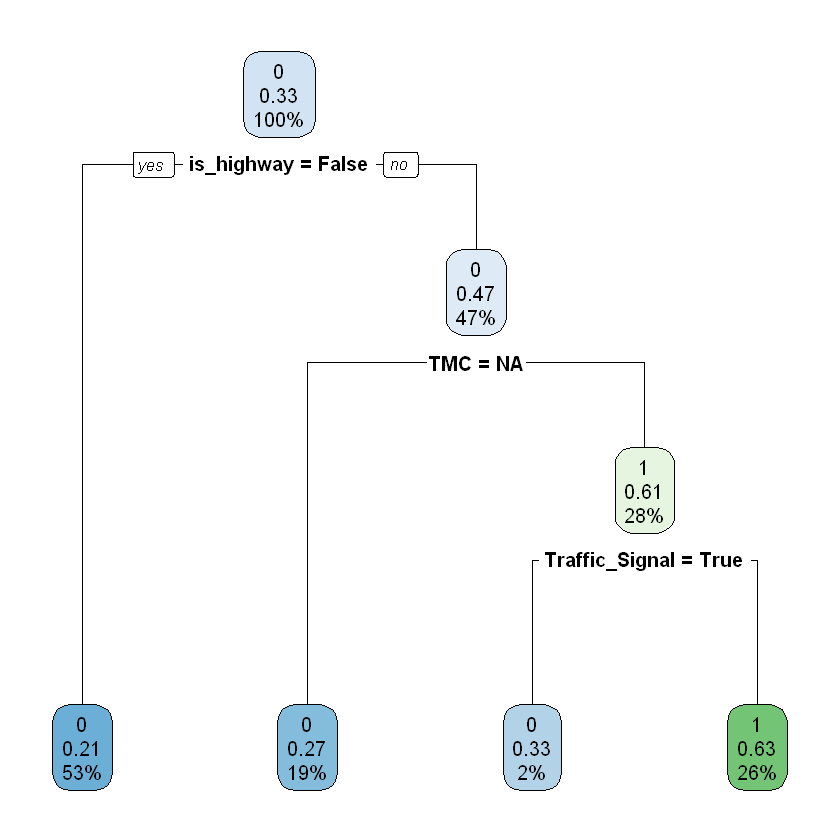

In [26]:
glm.COL <- c("Temperature.F.",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather",
             "Wind_Direction",
             "Distance.mi.",
             "TMC"
            )

run_dt(glm.COL)

$obj
n= 160001 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 160001 53357 0 (0.6665208 0.3334792)  
   2) is_highway=False 84040 17440 0 (0.7924798 0.2075202) *
   3) is_highway=True 75961 35917 0 (0.5271653 0.4728347)  
     6) TMC=NA 30954  8396 0 (0.7287588 0.2712412) *
     7) TMC=200,201,202,203,206,222,229,236,241,244,245,246,247,248,336,339,341,343,406 45007 17486 1 (0.3885173 0.6114827)  
      14) Traffic_Signal=True 2702   882 0 (0.6735751 0.3264249) *
      15) Traffic_Signal=False 42305 15666 1 (0.3703108 0.6296892) *

$snipped.nodes
NULL

$xlim
[1] 0 1

$ylim
[1] 0 1

$x
[1] 0.30830020 0.03992047 0.57667992 0.34664016 0.80671968 0.65335984 0.96007953

$y
[1] 0.93199421 0.04135776 0.66210437 0.04135776 0.39221454 0.04135776 0.04135776

$branch.x
       [,1]       [,2]      [,3]      [,4]      [,5]      [,6]      [,7]
x 0.3083002 0.03992047 0.5766799 0.3466402 0.8067197 0.6533598 0.9600795
         NA 0.03992047 0.5766799 0.3466402 0.8067197 

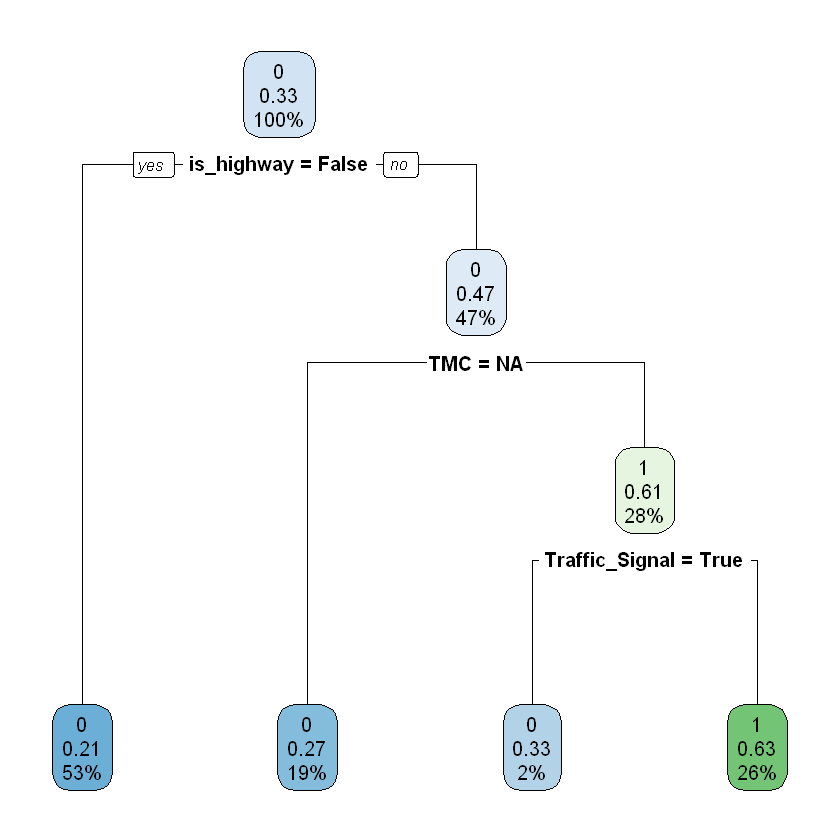

In [27]:
glm.COL <- c(
             "Traffic_Signal",
             "is_highway",
             "TMC"
            )

run_dt(glm.COL)

# L1 on GLM

In [28]:
glm.COL <- c("Temperature.F.",
             "Wind_Chill.F.",
             "Humidity...",
             "Pressure.in.",
             "Visibility.mi.",
             "Wind_Speed.mph.",
             "Distance.mi.",
              "is_highway",
             "Traffic_Signal"
            )

lambda <- 10^seq(10,-2,length=100)
lasso.mod <- glmnet(
    as.matrix( sapply( traffic.train.df[,glm.COL], as.numeric )),
    traffic.train.df[,"Severity"],
    family=binomial,
    alpha=1,
    lambda=lambda)
summary(lasso.mod)

          Length Class     Mode   
a0        100    -none-    numeric
beta      900    dgCMatrix S4     
df        100    -none-    numeric
dim         2    -none-    numeric
lambda    100    -none-    numeric
dev.ratio 100    -none-    numeric
nulldev     1    -none-    numeric
npasses     1    -none-    numeric
jerr        1    -none-    numeric
offset      1    -none-    logical
call        6    -none-    call   
family     12    family    list   
nobs        1    -none-    numeric

In [29]:
set.seed(42)
swiss.cv.out<-cv.glmnet(
    as.matrix( sapply( traffic.train.df[,glm.COL], as.numeric )),
    traffic.train.df[,"Severity"],
    family=binomial,
  alpha=1,   # alpha=1 as lasso
  parallel = TRUE)
best.lambda <- swiss.cv.out$lambda.min
best.lambda

Warning message:
"executing %dopar% sequentially: no parallel backend registered"


[1] 0.0007236864

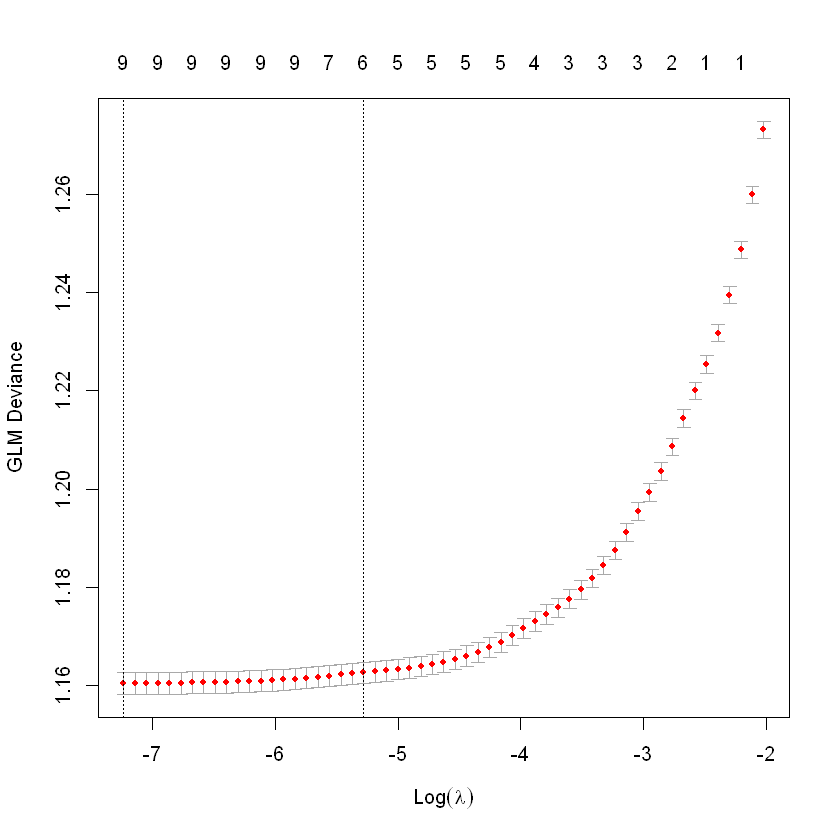

In [30]:
plot(swiss.cv.out)

In [31]:
# test

lasso.pred <- predict(
    lasso.mod,
    s=best.lambda,
    newx=as.matrix( sapply( traffic.test.df[,glm.COL], as.numeric )),
    type="response",
)


In [32]:
predict(lasso.mod,type="coef", s=best.lambda)

10 x 1 sparse Matrix of class "dgCMatrix"
                           1
(Intercept)     -3.869037259
Temperature.F.   .          
Wind_Chill.F.    .          
Humidity...      .          
Pressure.in.     0.081668916
Visibility.mi.   .          
Wind_Speed.mph.  0.008904345
Distance.mi.     0.111850245
is_highway       0.969244253
Traffic_Signal  -0.743849349

In [33]:
# train set
lasso.pred <- predict(
    lasso.mod,
    s=best.lambda,
    newx=as.matrix( sapply( traffic.train.df[,glm.COL], as.numeric )),
    type="response",
    )
traffic.train.preds <- rep(
    0,
    nrow(traffic.train.df)
)
traffic.train.preds[lasso.pred>.5]=1
traffic.train.preds <- as.factor(traffic.train.preds)

# test set
lasso.pred <- predict(
    lasso.mod,
    s=best.lambda,
    newx=as.matrix( sapply( traffic.test.df[,glm.COL], as.numeric )),
    type="response",
)
traffic.test.preds <- rep(
    0,
    nrow(traffic.test.df)
)
traffic.test.preds[lasso.pred>.5]=1
traffic.test.preds <- as.factor(traffic.test.preds)

print(confusionMatrix(
    traffic.train.preds, 
    traffic.train.df$Severity, 
    positive='1',
))

print(confusionMatrix(
    traffic.test.preds, 
    traffic.test.df$Severity, 
    positive='1'
))

Confusion Matrix and Statistics

          Reference
Prediction      0      1
         0 104034  49100
         1   2610   4257
                                          
               Accuracy : 0.6768          
                 95% CI : (0.6745, 0.6791)
    No Information Rate : 0.6665          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.0707          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.07978         
            Specificity : 0.97553         
         Pos Pred Value : 0.61992         
         Neg Pred Value : 0.67937         
             Prevalence : 0.33348         
         Detection Rate : 0.02661         
   Detection Prevalence : 0.04292         
      Balanced Accuracy : 0.52765         
                                          
       'Positive' Class : 1               
            

In [34]:
glm.COL <- c(
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Traffic_Signal",
             "is_highway",
             "Distance.mi."
            )

run_glm(glm.COL)

[1] "Pressure.in."    "Wind_Speed.mph." "Traffic_Signal"  "is_highway"     
[5] "Distance.mi."   

Call:
glm(formula = as.formula(paste("Severity~", paste(COL, collapse = "+"))), 
    family = binomial, data = traffic.train.df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-7.1574  -0.8144  -0.6939   1.2004   2.4593  

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -6.278318   0.246044  -25.52   <2e-16 ***
Pressure.in.        0.165413   0.008217   20.13   <2e-16 ***
Wind_Speed.mph.     0.020097   0.001170   17.18   <2e-16 ***
Traffic_SignalTrue -0.910869   0.019814  -45.97   <2e-16 ***
is_highwayTrue      1.046924   0.011733   89.23   <2e-16 ***
Distance.mi.        0.168277   0.005093   33.04   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 203718  on 160000  degrees of freedom
Residual deviance: 185885  on 159

# SVM

In [41]:
svm.train.df <- traffic.train.df[sample(nrow(traffic.train.df), 10000), ]
svm.test.df <- traffic.test.df[sample(nrow(traffic.test.df), 10000), ]

glm.COL <- c("Temperature.F.",
             "Pressure.in.",
             "Wind_Speed.mph.",
             "Sunrise_Sunset",
             "Traffic_Signal",
             "region",
             "is_highway",
             "Weather",
             "Wind_Direction",
             "Distance.mi.",
             "TMC"
            )

traffic.svm <- svm(
    as.formula(paste("Severity~", paste(glm.COL, collapse = "+"))),
    data=svm.train.df)

In [42]:
summary(traffic.svm)


Call:
svm(formula = as.formula(paste("Severity~", paste(glm.COL, collapse = "+"))), 
    data = svm.train.df)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  6530

 ( 3284 3246 )


Number of Classes:  2 

Levels: 
 0 1




In [44]:
y.train.preds <- predict(traffic.svm)
confusionMatrix(y.train.preds, svm.train.df$Severity, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 5432 1601
         1 1140 1827
                                         
               Accuracy : 0.7259         
                 95% CI : (0.717, 0.7346)
    No Information Rate : 0.6572         
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.3714         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.5330         
            Specificity : 0.8265         
         Pos Pred Value : 0.6158         
         Neg Pred Value : 0.7724         
             Prevalence : 0.3428         
         Detection Rate : 0.1827         
   Detection Prevalence : 0.2967         
      Balanced Accuracy : 0.6798         
                                         
       'Positive' Class : 1              
                                         

In [45]:
y.test.preds <- predict(traffic.svm)
confusionMatrix(y.test.preds, svm.test.df$Severity, positive="1")

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 4718 2315
         1 1964 1003
                                          
               Accuracy : 0.5721          
                 95% CI : (0.5623, 0.5818)
    No Information Rate : 0.6682          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0086          
                                          
 Mcnemar's Test P-Value : 8.77e-08        
                                          
            Sensitivity : 0.3023          
            Specificity : 0.7061          
         Pos Pred Value : 0.3381          
         Neg Pred Value : 0.6708          
             Prevalence : 0.3318          
         Detection Rate : 0.1003          
   Detection Prevalence : 0.2967          
      Balanced Accuracy : 0.5042          
                                          
       'Positive' Class : 1               
                        